In [1]:
import tqdm

In [2]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

## Optical digits

In [3]:
train_file = './uci_repos/optical_digits/optdigits.tra'
test_file = './uci_repos/optical_digits/optdigits.tes'
column = ['pixel_'+str(i) for i in range(64)]
column.append('digit_label')
train_data = pd.read_csv(train_file, sep=',', header=None, names=column)
test_data = pd.read_csv(test_file, sep=',', header=None, names=column)

In [4]:
test_data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63,digit_label
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [5]:
def group_all_labels(data, num=100, minor=[]):
    # this function is to limit the number of labels that are used
    # it returns the indexes according the labels
    # data is an array of labels
    '''

    :param data: array of labels
    :param num: number required
    :param minor: list of minority indexes
    :return: array of labels indexes
    '''

    labels = np.unique(data)
    co_l = []
    min_col =[]
    if not minor:
        for l in labels:
            el_l = np.where(np.array(data) == l)
            co_l.append(el_l[0])

    else:
        for l in labels:
            if l in minor:
                el_l = np.where(np.array(data) == l)
                co_l.append((el_l[0])[:num])
                min_col.append((el_l[0])[:num])
            else:
                el_l = np.where(np.array(data) == l)
                co_l.append(el_l[0])
    return co_l, min_col

In [6]:
train_y = train_data.iloc[:,-1:].copy().to_numpy()
train_images = train_data.iloc[:, 0:-1].copy().to_numpy()
y_test = test_data.iloc[:,-1:].copy().to_numpy()
test_images = test_data.iloc[:, 0:-1].copy().to_numpy()

In [7]:
grouped_labels, min_label = group_all_labels(train_y, 100, [0, 1])
gr_data = []
gr_labels = [] 
for index, q in enumerate(grouped_labels):
    print('class {} : number of samples : {}'.format(index,len(q)))
    for r in q:
        gr_data.append(train_images[r])
        gr_labels.append(train_y[r])

class 0 : number of samples : 100
class 1 : number of samples : 100
class 2 : number of samples : 380
class 3 : number of samples : 389
class 4 : number of samples : 387
class 5 : number of samples : 376
class 6 : number of samples : 377
class 7 : number of samples : 387
class 8 : number of samples : 380
class 9 : number of samples : 382


In [8]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

train image size :  (3258, 64)
train y size :  (3258, 10)
test image size :  (1797, 64)
test y size :  (1797, 10)
sample y : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


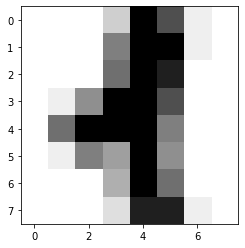

In [9]:
#train_images = [np.reshape(x, (8,8, 1)) for x in train_images ]
train_images = np.array(gr_data).astype(np.float32) / 16.0
#test_images = [np.reshape(x, (8,8, 1)) for x in test_images ]
test_images = np.array(test_images).astype(np.float32) / 16.0

train_y = tf.keras.utils.to_categorical(gr_labels, num_classes=10, dtype='float32')
test_y = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')
print('train image size : ', train_images.shape)
print('train y size : ', train_y.shape)
print('test image size : ', test_images.shape)
print('test y size : ', test_y.shape)
print('sample y :', train_y[0])
plt.imshow(np.reshape(train_images[100],(8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

### VAE

In [10]:
import tensorflow.compat.v1  as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np

mb_size = 64
z_dim = 10
X_dim = 64
y_dim = 10
h_dim = 16
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(8, 8), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)


# Q(z|X) 

X = tf.keras.Input(shape=(X_dim,))
c = tf.keras.Input(shape=(y_dim,))
z = tf.keras.Input(shape=(z_dim,))

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# P(X|z)

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

# gradient step
solver = tf.compat.v1.train.AdamOptimizer().minimize(vae_loss)
sess = tf.compat.v1.Session ()
sess.run(
tf.compat.v1.global_variables_initializer())

# if not os.path.exists('samples_opt_100/'):
#     os.makedirs('samples_opt_100/')

i = 0

for it in range(100000):
    ind = np.random.choice(train_images.shape[0], mb_size)
    X_mb = np.array(train_images[ind])
    y_mb = np.array(train_y[ind])
    
    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.2}'. format(loss))

#         y = np.zeros(shape=[64, y_dim])
#         y[:, np.random.randint(0, y_dim)] = 1.

#         samples = sess.run(X_samples,
#                            feed_dict={z: np.random.randn(64, z_dim), c: y})

#         fig = plot(samples)
#         plt.savefig('samples_opt_100/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
#         i += 1
#         plt.close(fig)



Instructions for updating:
non-resource variables are not supported in the long term


2021-10-11 08:23:39.185316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-11 08:23:39.197629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-10-11 08:23:39.198865: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-10-11 08:23:39.200272: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

Iter: 0
Loss: 6.5e+01
Iter: 1000
Loss: 2.4e+01
Iter: 2000
Loss: 2.2e+01
Iter: 3000
Loss: 2.1e+01
Iter: 4000
Loss: 2.2e+01
Iter: 5000
Loss: 2.2e+01
Iter: 6000
Loss: 2.2e+01
Iter: 7000
Loss: 2.2e+01
Iter: 8000
Loss: 2.2e+01
Iter: 9000
Loss: 2.1e+01
Iter: 10000
Loss: 2.1e+01
Iter: 11000
Loss: 2.1e+01
Iter: 12000
Loss: 2.2e+01
Iter: 13000
Loss: 2.2e+01
Iter: 14000
Loss: 2.2e+01
Iter: 15000
Loss: 2.2e+01
Iter: 16000
Loss: 2.2e+01
Iter: 17000
Loss: 2.2e+01
Iter: 18000
Loss: 2.1e+01
Iter: 19000
Loss: 2.1e+01
Iter: 20000
Loss: 2.1e+01
Iter: 21000
Loss: 2.2e+01
Iter: 22000
Loss: 2.2e+01
Iter: 23000
Loss: 2.1e+01
Iter: 24000
Loss: 2.1e+01
Iter: 25000
Loss: 2.2e+01
Iter: 26000
Loss: 2.1e+01
Iter: 27000
Loss: 2.2e+01
Iter: 28000
Loss: 2.2e+01
Iter: 29000
Loss: 2.1e+01
Iter: 30000
Loss: 2.1e+01
Iter: 31000
Loss: 2.2e+01
Iter: 32000
Loss: 2.2e+01
Iter: 33000
Loss: 2.1e+01
Iter: 34000
Loss: 2.1e+01
Iter: 35000
Loss: 2.1e+01
Iter: 36000
Loss: 2.1e+01
Iter: 37000
Loss: 2.1e+01
Iter: 38000
Loss: 2.1e+01

In [11]:
### generating sample outputs after training
def generate_samples():
    samples = []
    gen_labels =[]
    for r in range(10):
        for index in range(2):
            gen_labels = gen_labels + [index]*64
            y = np.zeros([mb_size, y_dim])
            y[range(mb_size), index] = 1
            samples.extend(sess.run(X_samples,
                                   feed_dict={z: np.random.randn(64, z_dim), c: y}))

    gen_samples = np.array(samples)
    gen_labels = np.array(gen_labels)
    
    return gen_samples, gen_labels

# Visualize generated samples

In [13]:
aug_samples, aug_labels = generate_samples()
aug_samples.shape, aug_labels.shape 

((1280, 64), (1280,))

1


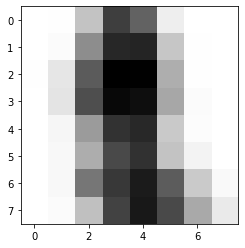

In [15]:
print(aug_labels[70])
plt.imshow(np.reshape(aug_samples[70],(8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

In [14]:
# normiziling pixel between 0..16 similar to the original data.
#norm_xtrain = (16*(gen_samples - np.min(gen_samples))/np.ptp(gen_samples)).astype(int) 

# MLP Model

In [17]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Flatten
from tensorflow.keras.models import Sequential


def build_model(input_shape=(64,), num_classes=10):
    """

    :param input_shape: shape of input_data
    :param num_classes: number of classes
    :return: keras.model.sequential compiled with categorical cross-entropy loss
    """
    model = Sequential([
        Input(shape=input_shape),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

# Baseline Experiment

In [18]:
model = build_model()
batch_size=8
epochs=2
history = model.fit(train_images, train_y, batch_size=batch_size, epochs=epochs, 
                    validation_data=(test_images, test_y))
score = model.evaluate(test_images, test_y, verbose=0)
print('test loss: ',score[0])
print('test accuracy: ', score[1] )
y_pred_oh = model.predict(test_images)
y_pred_baseline = y_pred_oh.argmax(axis=-1)
from sklearn.metrics import classification_report
print('MLP classification report\n',classification_report(y_test, y_pred_baseline))

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
__________________________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3258/3258 [==============================] - 1s 197us/sample - loss: 0.7116 - acc: 0.7744 - val_loss: 0.3504 - val_acc: 0.8859
test loss:  0.35044516841935397
test accuracy:  0.885921
MLP classification report
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       178
           1       0.95      0.58      0.72       182
           2       0.95      0.92      0.93       177
           3       0.87      0.93      0.90       183
           4       0.91      0.98      0.94       181
           5       0.88      0.96      0.92       182
           6       0.97      0.94      0.95       181
           7       0.94      0.93      0.94       179
           8       0.67      0.86      0.76       174
           9       0.81      0.84      0.83       180

    accuracy                           0.89      1797
   macro avg       0.90      0.89      0.88      1797
weighted avg       0.90      0.89      0.88      1797



# Augmentation Experiment

In [21]:
results_list = []
for i in range(10):
    gen_samples, gen_labels = generate_samples()
    gen_y = tf.keras.utils.to_categorical(gen_labels, num_classes=10, dtype='float32')
    X = np.concatenate([train_images, gen_samples])
    Y = np.concatenate([train_y, gen_y])
    model_aug = build_model()
    history_aug = model_aug.fit(X, Y, batch_size=batch_size, epochs=epochs, validation_data=(test_images, test_y))
    
    aug_score = model_aug.evaluate(test_images, test_y, verbose=0)
    print('test loss for {}th run: '.format(i), aug_score[0])
    print('test accuracy for {}th run: '.format(i), aug_score[1] )
    
    y_pred_aug_oh = model_aug.predict(test_images)
    y_pred_aug = y_pred_aug_oh.argmax(axis=-1)
    results_list.append(classification_report(y_test, y_pred_aug, output_dict=True))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32)                128       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 351us/sample - loss: 1.1808 - acc: 0.6437 - val_loss: 0.4949 - val_acc: 0.8414
Epoch 2/2
4538/4538 [==============================] - 1s 238us/sample - loss: 0.5016 - acc: 0.8480 - val_loss: 0.3544 - val_acc: 0.8854
test loss for 1th run:  0.3543548403296394
test accuracy for 1th run:  0.8853645
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32)                128       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_11 (Batc (None, 64)                256       
_______________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 361us/sample - loss: 1.1637 - acc: 0.6386 - val_loss: 0.4999 - val_acc: 0.8486
Epoch 2/2
4538/4538 [==============================] - 1s 293us/sample - loss: 0.5273 - acc: 0.8411 - val_loss: 0.3724 - val_acc: 0.8848
test loss for 2th run:  0.37239183796674397
test accuracy for 2th run:  0.884808
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_______________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 1s 294us/sample - loss: 1.2020 - acc: 0.6338 - val_loss: 0.4214 - val_acc: 0.8587
Epoch 2/2
4538/4538 [==============================] - 1s 251us/sample - loss: 0.4637 - acc: 0.8590 - val_loss: 0.3443 - val_acc: 0.8965
test loss for 3th run:  0.34433563323339067
test accuracy for 3th run:  0.89649415
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_14 (Batc (None, 32)                128       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_____________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 1s 261us/sample - loss: 1.1594 - acc: 0.6525 - val_loss: 0.4035 - val_acc: 0.8820
Epoch 2/2
4538/4538 [==============================] - 1s 191us/sample - loss: 0.4519 - acc: 0.8581 - val_loss: 0.3080 - val_acc: 0.9104
test loss for 4th run:  0.3080078124892201
test accuracy for 4th run:  0.91040623
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)                256       
______________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 334us/sample - loss: 1.1216 - acc: 0.6534 - val_loss: 0.4231 - val_acc: 0.8709
Epoch 2/2
4538/4538 [==============================] - 1s 232us/sample - loss: 0.4809 - acc: 0.8535 - val_loss: 0.2667 - val_acc: 0.9182
test loss for 5th run:  0.2666907929595089
test accuracy for 5th run:  0.918197
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32)                128       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)                256       
________________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 350us/sample - loss: 1.1364 - acc: 0.6589 - val_loss: 0.3828 - val_acc: 0.8854
Epoch 2/2
4538/4538 [==============================] - 1s 236us/sample - loss: 0.4727 - acc: 0.8607 - val_loss: 0.2880 - val_acc: 0.9093
test loss for 6th run:  0.28798717577694505
test accuracy for 6th run:  0.9092933
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
_____________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 362us/sample - loss: 1.2079 - acc: 0.6258 - val_loss: 0.4446 - val_acc: 0.8748
Epoch 2/2
4538/4538 [==============================] - 1s 263us/sample - loss: 0.5102 - acc: 0.8424 - val_loss: 0.4283 - val_acc: 0.8781
test loss for 7th run:  0.4282519989167576
test accuracy for 7th run:  0.8781302
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 32)                128       
_________________________________________________________________
dense_34 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_23 (Batc (None, 64)                256       
______________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 1s 328us/sample - loss: 1.1115 - acc: 0.6450 - val_loss: 0.4048 - val_acc: 0.8776
Epoch 2/2
4538/4538 [==============================] - 1s 241us/sample - loss: 0.5002 - acc: 0.8446 - val_loss: 0.2541 - val_acc: 0.9204
test loss for 8th run:  0.25410825875678456
test accuracy for 8th run:  0.9204229
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
dense_37 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_25 (Batc (None, 64)                256       
_____________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 358us/sample - loss: 1.1704 - acc: 0.6386 - val_loss: 0.3872 - val_acc: 0.8770
Epoch 2/2
4538/4538 [==============================] - 1s 275us/sample - loss: 0.5129 - acc: 0.8411 - val_loss: 0.3170 - val_acc: 0.9032
test loss for 9th run:  0.3170184850419105
test accuracy for 9th run:  0.90317196


In [22]:
import pandas as pd
total_df = pd.DataFrame(results_list[0]).transpose()
print(len(results_list))
for r_dict in results_list[1:]:
    temp = pd.DataFrame(r_dict).transpose()
    total_df = total_df.add(temp)
    
average_10x = total_df/10.0
average_10x

10


,precision,recall,f1-score,support
0,0.988365,0.946067,0.966562,178.000000
1,0.880562,0.747802,0.806863,182.000000
2,0.946145,0.922599,0.933711,177.000000
3,0.948845,0.892350,0.918403,183.000000
4,0.915618,0.953039,0.933575,181.000000
5,0.879266,0.971429,0.922740,182.000000
6,0.960471,0.967403,0.963772,181.000000
7,0.945362,0.876536,0.908705,179.000000
8,0.775652,0.851149,0.808888,174.000000
9,0.821834,0.882778,0.848503,180.000000
